# Auswertung XGBoost - Training Haber-Bosch und PICASO Bereich

#### Importe

In [1]:
import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import ConnectionPatch
from pathlib import Path
from sklearn.metrics import r2_score as r2
from sklearn.metrics import max_error
import timeit

#### Import Plotstyle Stylesheet

In [2]:
plt.style.use(['seaborn-v0_8-paper',Path.cwd().parent / 'plotstyle' / 'paper.mplstyle'])
cm = 1/2.54

#### Laden des Modells

In [3]:
xgb_model = xgb.Booster()
xgb_model.load_model(Path.cwd().parent /'data' / 'models' / 'xgb_011_032.json')

### Extrapolation

#### Laden und Preprocessing der GGW-Daten

In [54]:
# Daten Extrapolation
eq_data_file_extra = Path.cwd().parent / 'data' / 'eq_dataset_x_extra_haber_picaso.npz' #Import der GGW Daten
extra_data = np.load(eq_data_file_extra)

# Bei Speicherung wurden Daten als T, p, x_0 und x gespeichert
# Inputs T, p, x_0[H2,N2,NH3]
# Output x[NH3]
T = np.array(extra_data['T'])
p = np.array(extra_data['p'])
x_0 = np.array(extra_data['x_0'])
x = np.array(extra_data['x'])
#print(x)
X = np.stack((T, p , x_0[:,0],x_0[:,1],x_0[:,2]),axis=1)
y = np.stack((x[:,0], x[:,1]), axis=1) # [H2, NH3], dritter Stoffmengenanteil ergibt sich den anderen

#### Vorhersage der GGW-Daten

In [55]:
dtest = xgb.DMatrix(X, y)
pred = xgb_model.predict(dtest)

#### Auswertung der Extrapolation in der Trainingslücke - Parity Plot

Training Dataset: R^2(H2) = 0.981793259653154 , R^2(NH3) = -1.4065889355038292
Max Error Training: |x_H2 - x_H2,pred| = 0.07935006807840106 , |x_NH3 - x_NH3,pred| = 0.8610537985733112


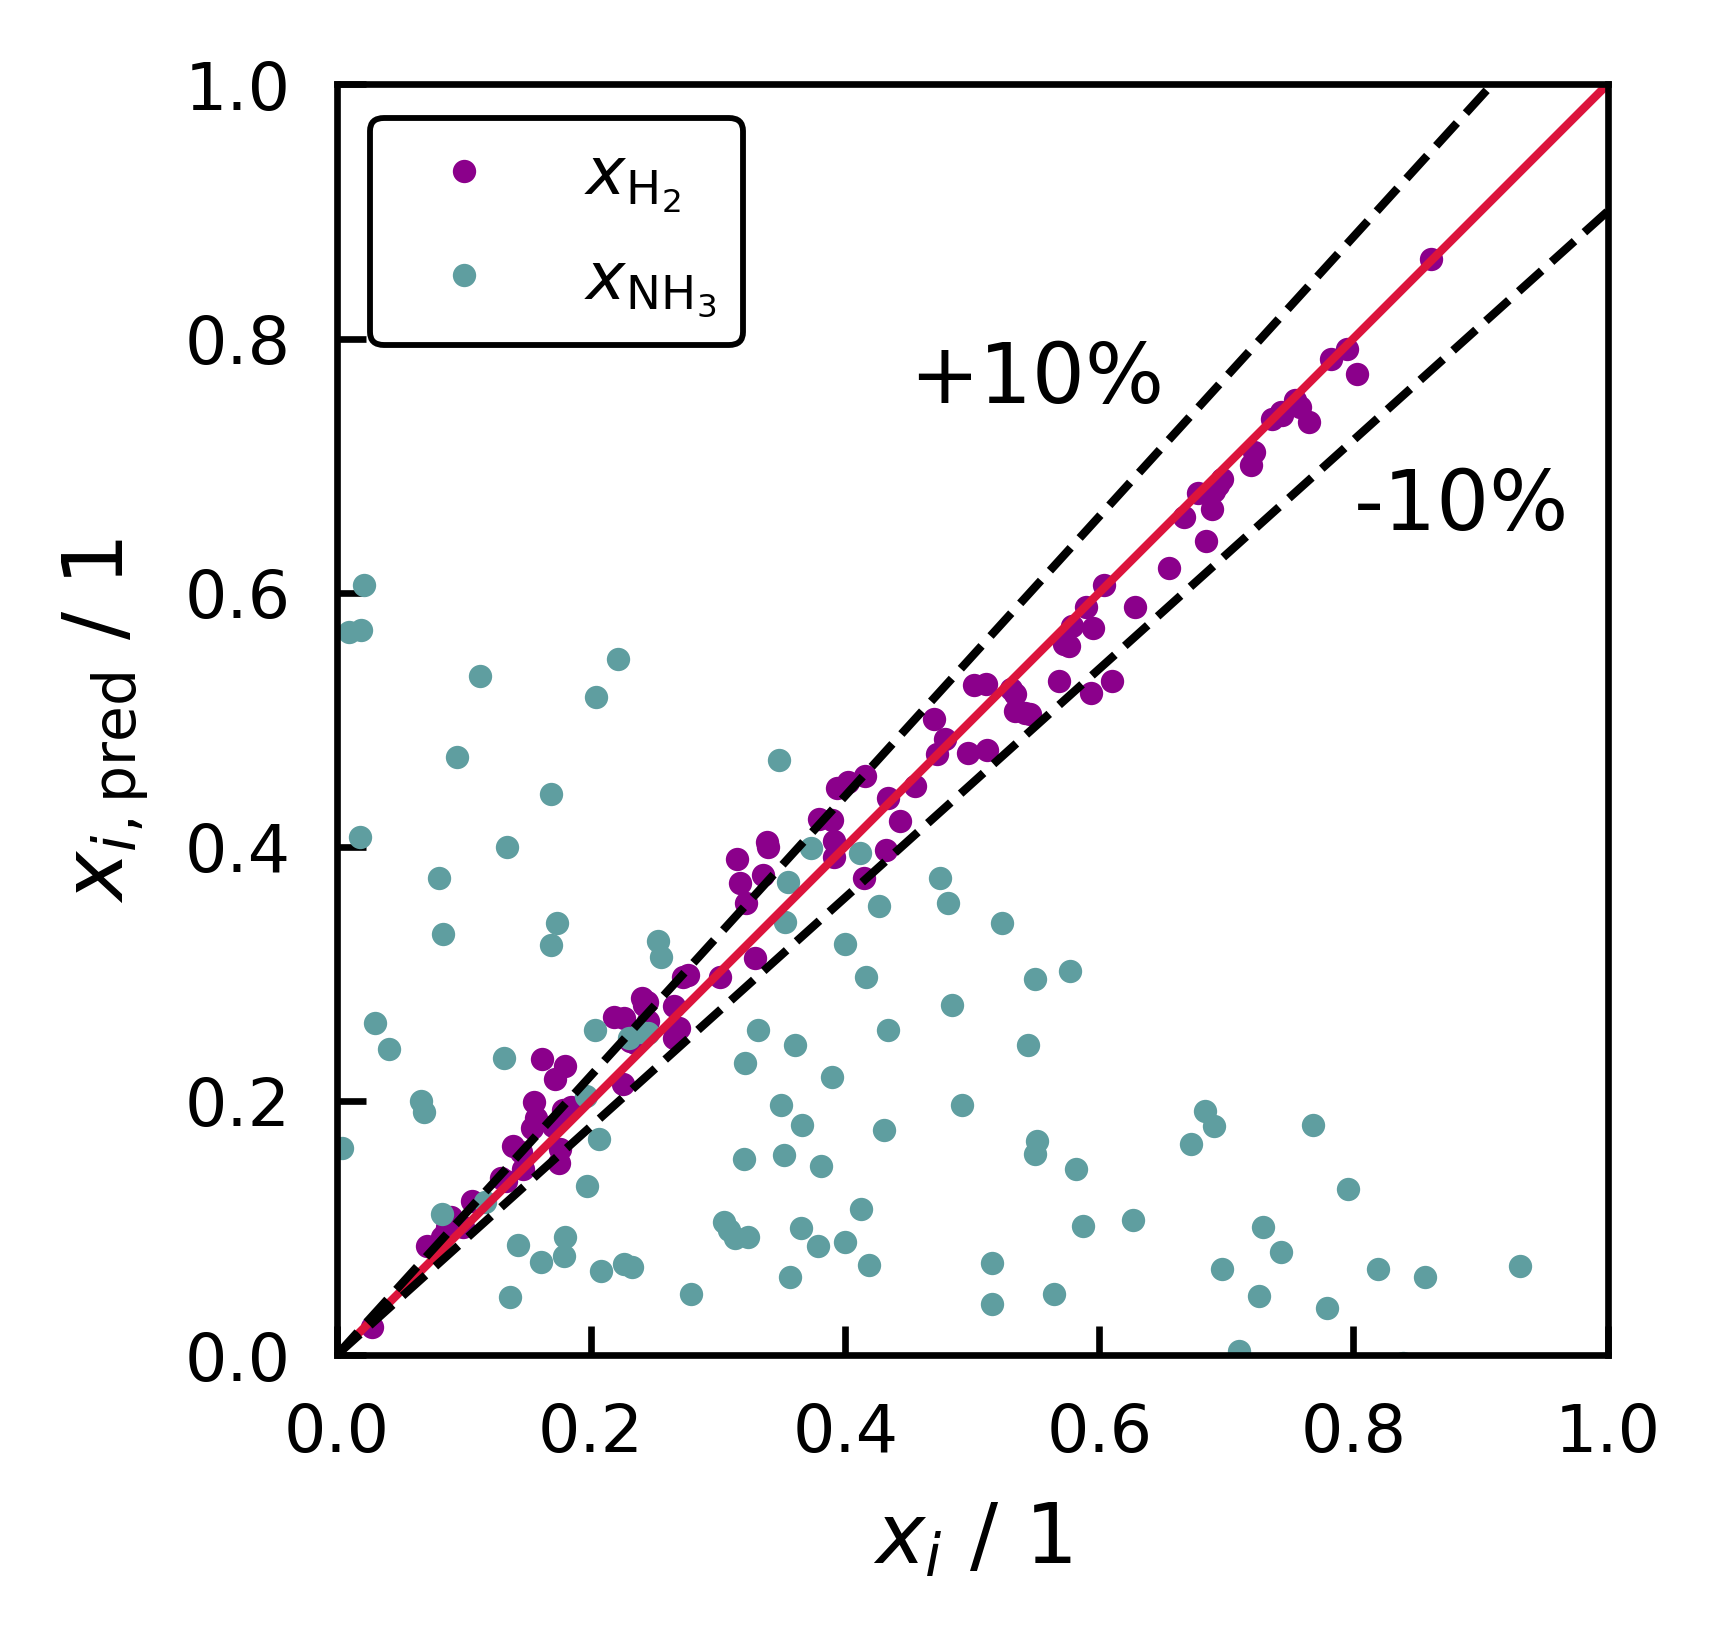

In [64]:
x_H2_real = y[:,0]
x_NH3_real = y[:,1]
x_H2_pred = pred[:,0] 
x_NH3_pred = pred[:,1]

print('Training Dataset: R^2(H2) =', r2(x_H2_real,x_H2_pred), ', R^2(NH3) =', r2(x_NH3_real,x_NH3_pred))
print('Max Error Training: |x_H2 - x_H2,pred| =', max_error(x_H2_real, x_H2_pred), ', |x_NH3 - x_NH3,pred| =', max_error(x_NH3_real, x_NH3_pred))

# find the boundaries of X and Y values
bounds = (0,1)

fig,ax = plt.subplots(figsize =(7.5*cm,7.5*cm))

# # Reset the limits
# ax[0] = plt.gca()
ax.set_xlim(bounds)
ax.set_ylim(bounds)
# Ensure the aspect ratio is square
ax.set_aspect("equal", adjustable="box")

ax.plot(x_H2_real, x_H2_pred, '.', label = '$x\mathregular{_{H_2}}$')
ax.plot(x_NH3_real, x_NH3_pred, '.', label = '$x\mathregular{_{NH_3}}$')
ax.plot([0, 1], [0, 1], "-",color='crimson',lw=1 ,transform=ax.transAxes)
ax.plot([bounds[0],bounds[1]], [bounds[0] * 1.1, bounds[1] * 1.1], "k--", lw=1) # Error line
ax.plot([bounds[0],bounds[1]], [bounds[0] * 0.9, bounds[1] * 0.9], "k--", lw=1) # Error line
ax.text(0.45, 0.75, '+10%')
ax.text(0.8, 0.65, '-10%')
ax.set(xlabel = '$x_i$ / 1', ylabel = '$x_i\mathregular{_{,pred}}$ / 1')
ax.tick_params(direction = 'in') #, length = 20, width = 3)
#ax.set_title('Extrapolation Data')
ax.legend()
#ax.legend(['$\\mathregular{R^2}$ = ', r2(xi_real,xi_pred)], markerscale=0)

#plt.legend()
#fig.suptitle("Parity Plot")
plt.tight_layout()
plt.show()

In [65]:
#fig.savefig(Path.cwd().parent / 'plots/xgb/TKA_SRA_PB_014_parity_extra_5.png', bbox_inches = 'tight')

#### Debugging Hilfe

In [8]:
# print(X)
# print(y * std_out + mean_out)
# x_H2, x_NH3 = (net(X).detach().numpy()).T
# print(x_H2 * std_out[0].numpy() + mean_out[0].numpy(), ', ', x_NH3 * std_out[1].numpy() + mean_out[1].numpy())

### Wie weit extrapolierbar?

#### Laden und Preprocessing der Daten; p = const; x_0 = const

In [36]:
# Daten Extrapolation
eq_data_file_T_var_extra_haber_picaso = Path.cwd().parent / 'data' / 'eq_dataset_T_var_extra_haber_picaso.npz' #Import der GGW Daten
data_T_extra_haber_picaso = np.load(eq_data_file_T_var_extra_haber_picaso)

# Bei Speicherung wurden Daten als T, p, x_0 und x gespeichert
# Inputs T, p, x_0[H2,N2,NH3]
# Output x[NH3]
T = np.array(data_T_extra_haber_picaso['T'])
p = np.array(data_T_extra_haber_picaso['p'])
x_0 = np.array(data_T_extra_haber_picaso['x_0'])
x = np.array(data_T_extra_haber_picaso['x'])

#p[5,10,30,80,90,100,150,250] bar
X_1 = np.stack((T, np.full_like(T, p[0]) , np.full_like(T, x_0[0]),np.full_like(T, x_0[1]),np.full_like(T, x_0[2])),1)
y_1 = x[:,0] # [H2, NH3], dritter Stoffmengenanteil ergibt sich den anderen
X_2 = np.stack((T, np.full_like(T, p[1]) , np.full_like(T, x_0[0]),np.full_like(T, x_0[1]),np.full_like(T, x_0[2])),1)
y_2 = x[:,1] # [H2, NH3], dritter Stoffmengenanteil ergibt sich den anderen
X_3 = np.stack((T, np.full_like(T, p[2]) , np.full_like(T, x_0[0]),np.full_like(T, x_0[1]),np.full_like(T, x_0[2])),1)
y_3 = x[:,2] # [H2, NH3], dritter Stoffmengenanteil ergibt sich den anderen
X_4 = np.stack((T, np.full_like(T, p[3]) , np.full_like(T, x_0[0]),np.full_like(T, x_0[1]),np.full_like(T, x_0[2])),1)
y_4 = x[:,3] # [H2, NH3], dritter Stoffmengenanteil ergibt sich den anderen
X_5 = np.stack((T, np.full_like(T, p[4]) , np.full_like(T, x_0[0]),np.full_like(T, x_0[1]),np.full_like(T, x_0[2])),1)
y_5 = x[:,4] # [H2, NH3], dritter Stoffmengenanteil ergibt sich den anderen
X_6 = np.stack((T, np.full_like(T, p[5]) , np.full_like(T, x_0[0]),np.full_like(T, x_0[1]),np.full_like(T, x_0[2])),1)
y_6 = x[:,5] # [H2, NH3], dritter Stoffmengenanteil ergibt sich den anderen
X_7 = np.stack((T, np.full_like(T, p[6]) , np.full_like(T, x_0[0]),np.full_like(T, x_0[1]),np.full_like(T, x_0[2])),1)
y_7 = x[:,6] # [H2, NH3], dritter Stoffmengenanteil ergibt sich den anderen
X_8 = np.stack((T, np.full_like(T, p[7]) , np.full_like(T, x_0[0]),np.full_like(T, x_0[1]),np.full_like(T, x_0[2])),1)
y_8 = x[:,7] # [H2, NH3], dritter Stoffmengenanteil ergibt sich den anderen
X_9 = np.stack((T, np.full_like(T, p[8]) , np.full_like(T, x_0[0]),np.full_like(T, x_0[1]),np.full_like(T, x_0[2])),1)
y_9 = x[:,8] # [H2, NH3], dritter Stoffmengenanteil ergibt sich den anderen
#print(np.shape(x))

#### Vorhersage der GGW Daten

In [37]:
dtest_1 = xgb.DMatrix(X_1, y_1)
dtest_2 = xgb.DMatrix(X_2, y_2)
dtest_3 = xgb.DMatrix(X_3, y_3)
dtest_4 = xgb.DMatrix(X_4, y_4)
dtest_5 = xgb.DMatrix(X_5, y_5)
dtest_6 = xgb.DMatrix(X_6, y_6)
dtest_7 = xgb.DMatrix(X_7, y_7)
dtest_8 = xgb.DMatrix(X_8, y_8)
dtest_9 = xgb.DMatrix(X_9, y_9)

pred_1 = xgb_model.predict(dtest_1)
pred_2 = xgb_model.predict(dtest_2)
pred_3 = xgb_model.predict(dtest_3)
pred_4 = xgb_model.predict(dtest_4)
pred_5 = xgb_model.predict(dtest_5)
pred_6 = xgb_model.predict(dtest_6)
pred_7 = xgb_model.predict(dtest_7)
pred_8 = xgb_model.predict(dtest_8)
pred_9 = xgb_model.predict(dtest_9)

#### Auswertung Verlauf x_NH3 über T, p =const, x_0 = const, Inter- und Extrapolation

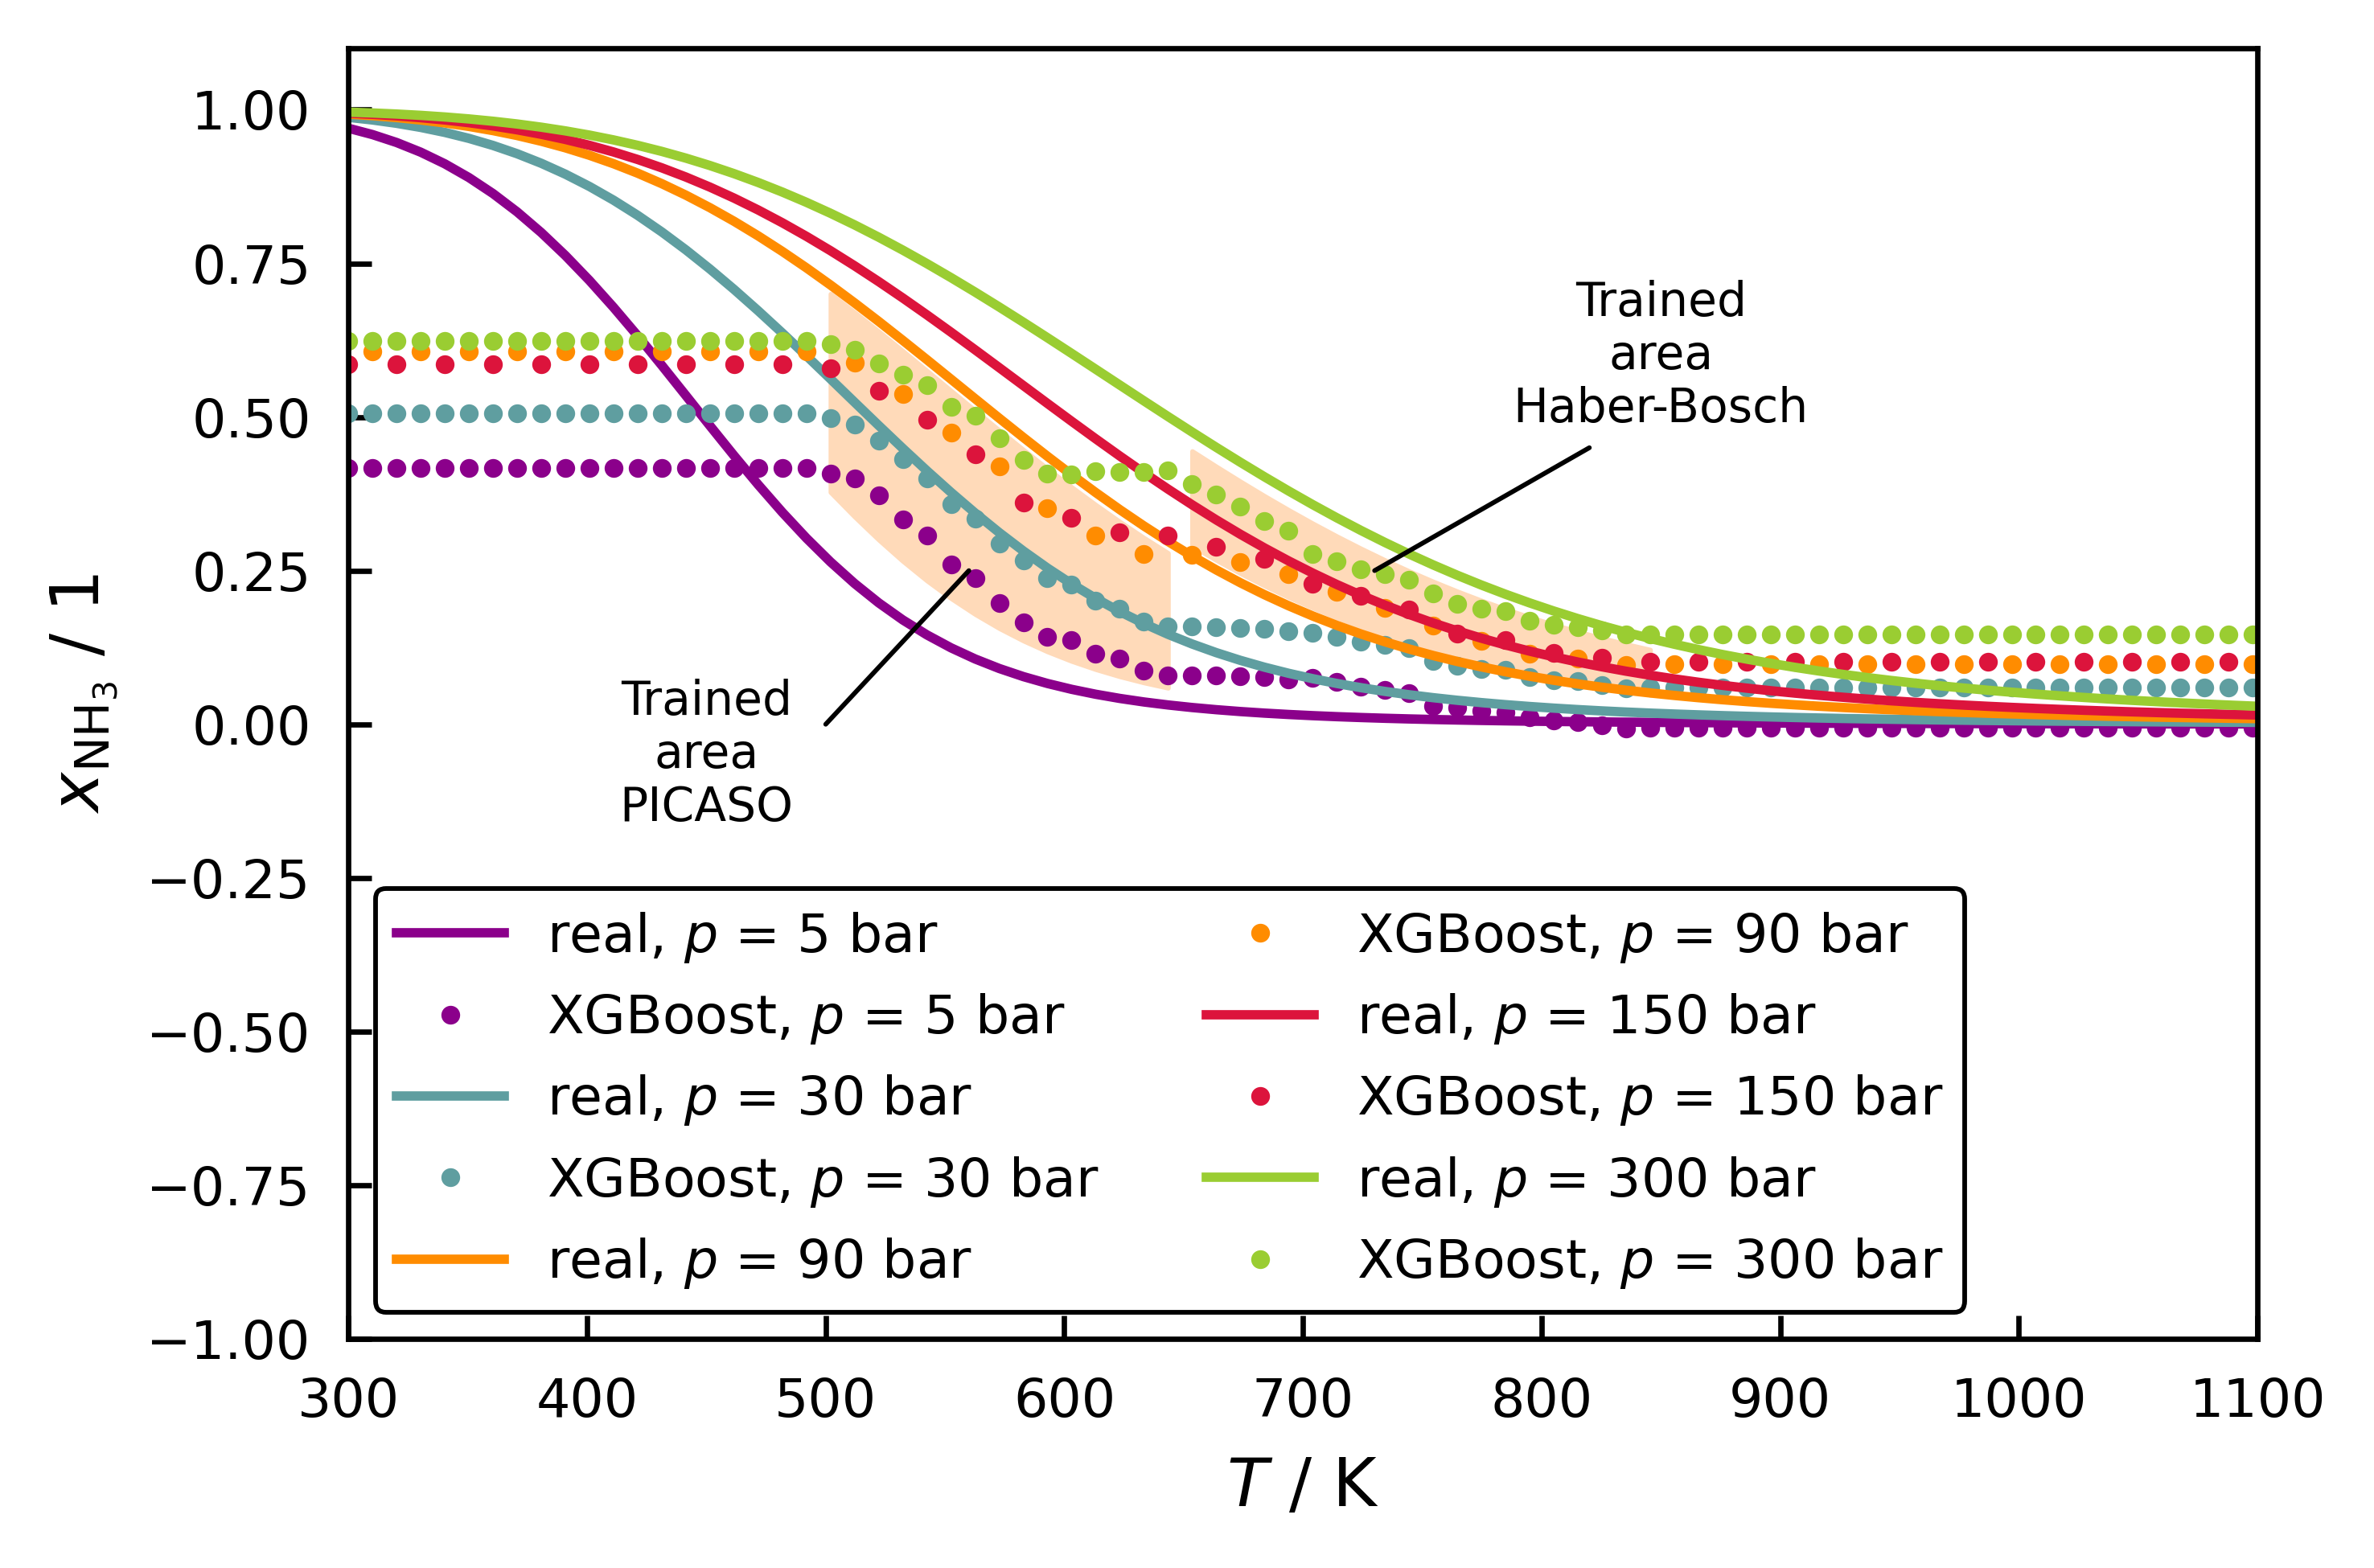

In [38]:
x_NH3_real_1 = y_1
x_NH3_pred_1 = pred_1[:,1]
x_NH3_real_2 = y_2
x_NH3_pred_2 = pred_2[:,1]
x_NH3_real_3 = y_3
x_NH3_pred_3 = pred_3[:,1]
x_NH3_real_4 = y_4
x_NH3_pred_4 = pred_4[:,1]
x_NH3_real_5 = y_5
x_NH3_pred_5 = pred_5[:,1]
x_NH3_real_6 = y_6
x_NH3_pred_6 = pred_6[:,1]
x_NH3_real_7 = y_7
x_NH3_pred_7 = pred_7[:,1]
x_NH3_real_8 = y_8
x_NH3_pred_8 = pred_8[:,1]
x_NH3_real_9 = y_9
x_NH3_pred_9 = pred_9[:,1]

fig,ax = plt.subplots()

ax.plot(X_1[:,0], x_NH3_real_1, '-', color ='darkmagenta', label = 'real, $p$ = 5 bar')
ax.plot(X_1[:,0], x_NH3_pred_1, '.', color ='darkmagenta', label = 'XGBoost, $p$ = 5 bar')
#ax.plot(X_2[:,0], x_NH3_real_2, '--', color ='grey')#, label = 'real, p = 10 bar')
#ax.plot(X_2[:,0], x_NH3_pred_2, '.', color ='gold', label = 'aNN, p = 10 bar')
ax.plot(X_3[:,0], x_NH3_real_3, '-', color ='cadetblue', label = 'real, $p$ = 30 bar')
ax.plot(X_3[:,0], x_NH3_pred_3, '.', color ='cadetblue', label = 'XGBoost, $p$ = 30 bar')
#ax.plot(X_4[:,0], x_NH3_real_4, '--', color ='grey')#, label = 'real, p = 80 bar')
#ax.plot(X_4[:,0], x_NH3_pred_4, '.', color ='mediumorchid', label = 'aNN, p = 80 bar')
ax.plot(X_5[:,0], x_NH3_real_5, '-', color ='darkorange', label = 'real, $p$ = 90 bar')
ax.plot(X_5[1:,0][::2], x_NH3_pred_5[1:][::2], '.', color ='darkorange', label = 'XGBoost, $p$ = 90 bar')
#ax.plot(X_6[:,0], x_NH3_real_6, '--', color ='grey')#, label = 'real, p = 100 bar')
#ax.plot(X_6[:,0], x_NH3_pred_6, '.', color ='yellowgreen', label = 'aNN, p = 100 bar')
ax.plot(X_7[:,0], x_NH3_real_7, '-', color ='crimson', label = 'real, $p$ = 150 bar')
ax.plot(X_7[:,0][::2], x_NH3_pred_7[::2], '.', color ='crimson', label = 'XGBoost, $p$ = 150 bar')
#ax.plot(X_8[:,0], x_NH3_real_8, '--', color ='grey')#, label = 'real, p = 250 bar')
#ax.plot(X_8[:,0], x_NH3_pred_8, '.', color ='yellowgreen', label = 'aNN, p = 250 bar')
ax.plot(X_9[:,0], x_NH3_real_9, '-', color ='yellowgreen', label = 'real, $p$ = 300 bar')
ax.plot(X_9[:,0], x_NH3_pred_9, '.', color ='yellowgreen', label = 'XGBoost, $p$ = 300 bar')

#ax.axvline(x=500, color='black', linestyle='dashed')
#ax.axvline(x=650, color='black', linestyle='dashed')
#ax.axvline(x=850, color='black', linestyle='dashed')


ax.set(xlabel = '$T$ / K', ylabel = '$x\mathregular{_{NH_3}}$ / 1')
ax.tick_params(direction = 'in') #, length = 20, width = 3)
#ax.set_title('p = const, x_0 = const')
ax.set(xlim=(300,1100),ylim=(-1,1.1))

#fill in training arreas
X_help = X_2
index_500 = np.where(X_help[:,0] >= 500)[0][0]
index_650 = np.where(X_help[:,0] >= 650)[0][0]
index_850 = np.where(X_help[:,0] >= 850)[0][0]

# print(index_500)
# print(X_2[index_500:index_650,0])
ax.fill_between(X_2[index_500:index_650, 0],x_NH3_real_2[index_500:index_650], x_NH3_real_4[index_500:index_650], color = 'peachpuff')#, label = 'PICASO', alpha = 0.6)
ax.fill_between(X_2[index_650:index_850, 0],x_NH3_real_6[index_650:index_850], x_NH3_real_8[index_650:index_850], color = 'peachpuff')#, label = 'Haber-Bosch')#,alpha = 0.6)

# Beschriftung Flächen
ax.text(850, 0.6, "Trained\narea\nHaber-Bosch", ha='center', va='center', fontsize=7, color='black', zorder=100)
con = ConnectionPatch(xyA=(730, 0.25), coordsA=ax.transData,
                      xyB=(820,0.45), coordsB=ax.transData, lw = 0.7, zorder=100)
ax.add_artist(con)

ax.text(450, -0.05, "Trained\narea\nPICASO", ha='center', va='center', fontsize=7, color='black', zorder=100)
con = ConnectionPatch(xyA=(560, 0.25), coordsA=ax.transData,
                      xyB=(500,0), coordsB=ax.transData, lw = 0.7, zorder=100)
ax.add_artist(con)


ax.legend(ncols = 2)

#plt.legend()
#fig.suptitle("Parity Plot")
plt.tight_layout()
plt.show()

In [39]:
#fig.savefig(Path.cwd().parent / 'plots/xgb/TKA_SRA_PB_012_verlauf_extra_3.png', bbox_inches = 'tight')

#### Parity Plot

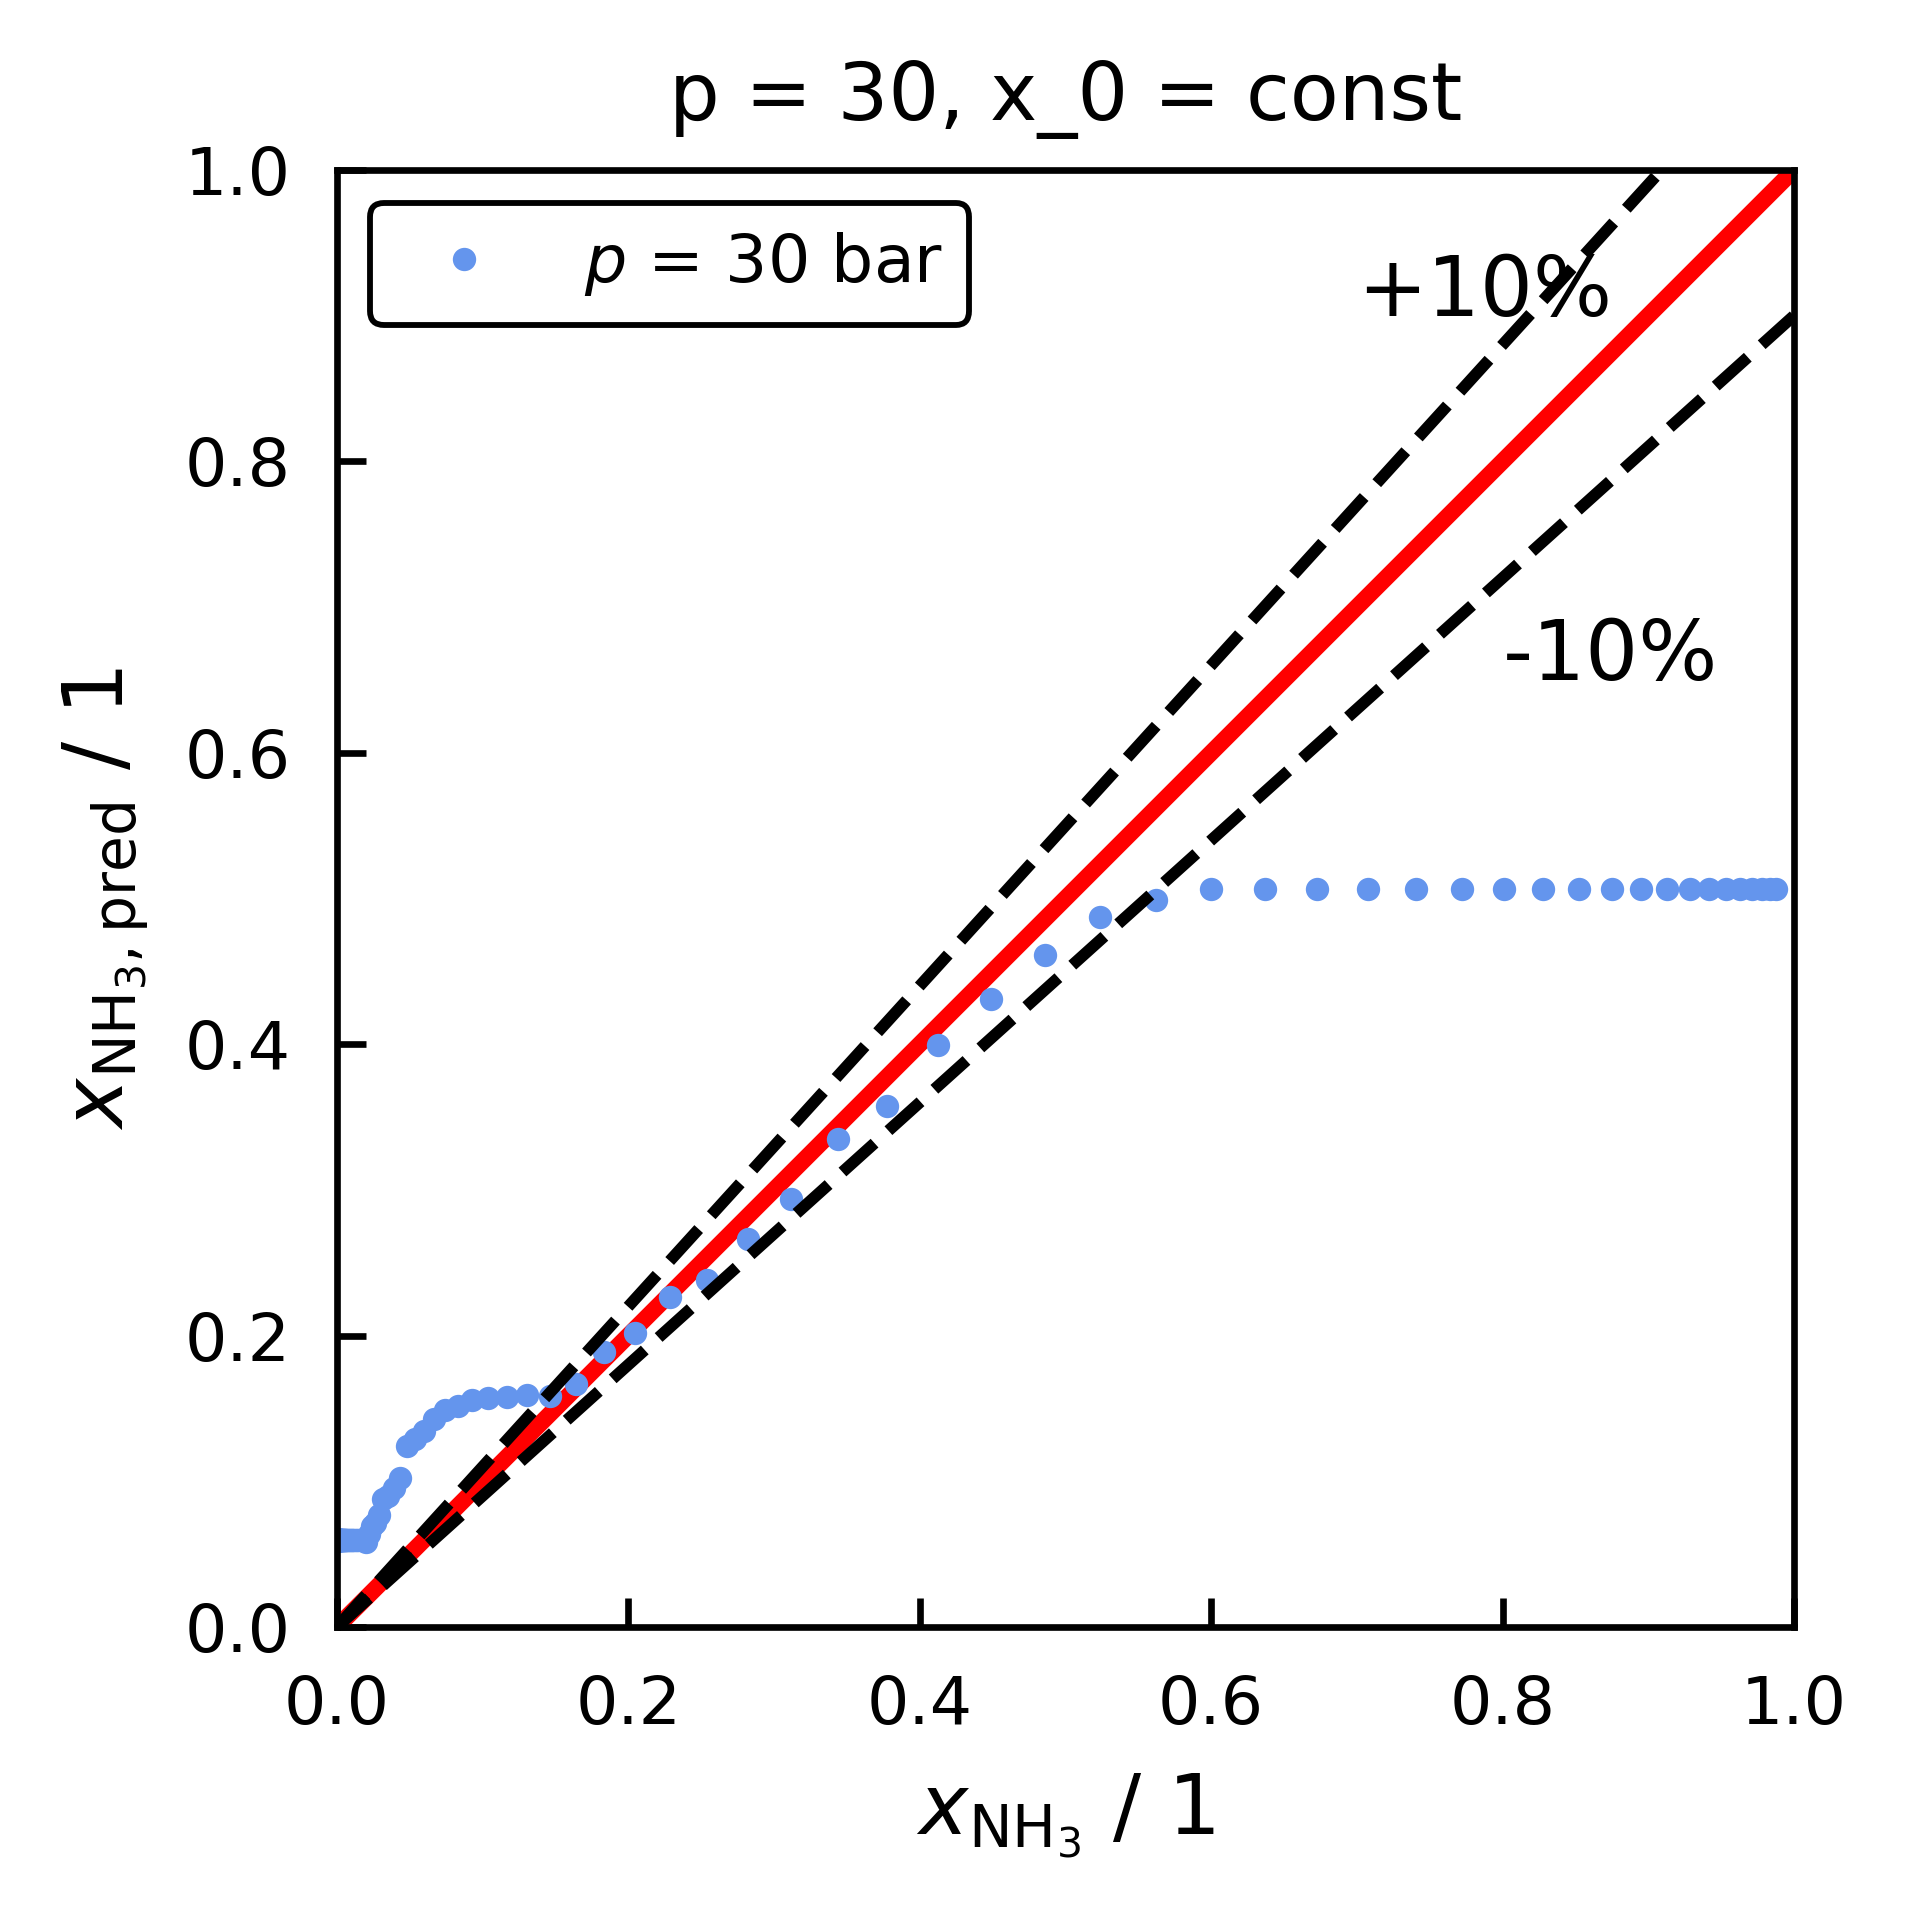

In [10]:
# Set the boundaries of X and Y values
bounds = (0,1)

fig,ax = plt.subplots(1, figsize =(3.3,3.3))

# # Reset the limits
# ax[0] = plt.gca()
ax.set_xlim(bounds)
ax.set_ylim(bounds)
# Ensure the aspect ratio is square
ax.set_aspect("equal", adjustable="box")

ax.plot([0, 1], [0, 1], "r-",lw=2 ,transform=ax.transAxes)
ax.plot(x_NH3_real_3, x_NH3_pred_3, '.', color ='cornflowerblue', label = '$p$ = 30 bar')
ax.plot([bounds[0],bounds[1]], [bounds[0] * 1.1, bounds[1] * 1.1], "k--") # Error line
ax.plot([bounds[0],bounds[1]], [bounds[0] * 0.9, bounds[1] * 0.9], "k--") # Error line
ax.text(0.7, 0.9, '+10%')
ax.text(0.8, 0.65, '-10%')
ax.set(xlabel = '$x\mathregular{_{NH_3}}$ / 1', ylabel = '$x\mathregular{_{NH_{3},pred}}$ / 1')
ax.tick_params(direction = 'in') #, length = 20, width = 3)
ax.set_title('p = 30, x_0 = const')
ax.legend()
#ax.legend(['$\\mathregular{R^2}$ = ', r2(xi_real,xi_pred)], markerscale=0)

#plt.legend()
#fig.suptitle("Parity Plot")
plt.tight_layout()
plt.show()

#### Laden und Preprocessing der Daten; T = const, x_0 = const

In [40]:
# Daten Extrapolation
eq_data_file_p_var_extra_haber = Path.cwd().parent / 'data' / 'eq_dataset_p_var_extra_haber_picaso.npz' #Import der GGW Daten
data_p_extra_haber = np.load(eq_data_file_p_var_extra_haber)

# Bei Speicherung wurden Daten als T, p, x_0 und x gespeichert
# Inputs T, p, x_0[H2,N2,NH3]
# Output x[NH3]
T = np.array(data_p_extra_haber['T'])
p = np.array(data_p_extra_haber['p'])
x_0 = np.array(data_p_extra_haber['x_0'])
x = np.array(data_p_extra_haber['x'])

#T[450,500,600,650,750,850,900] K
X_1 = np.stack((np.full_like(p, T[0]),p, np.full_like(p, x_0[0]),np.full_like(p, x_0[1]),np.full_like(p, x_0[2])),1)
y_1 = x[:,0] # [H2, NH3], dritter Stoffmengenanteil ergibt sich den anderen
X_2 = np.stack((np.full_like(p, T[1]),p, np.full_like(p, x_0[0]),np.full_like(p, x_0[1]),np.full_like(p, x_0[2])),1)
y_2 = x[:,1] # [H2, NH3], dritter Stoffmengenanteil ergibt sich den anderen
X_3 = np.stack((np.full_like(p, T[2]),p, np.full_like(p, x_0[0]),np.full_like(p, x_0[1]),np.full_like(p, x_0[2])),1)
y_3 = x[:,2] # [H2, NH3], dritter Stoffmengenanteil ergibt sich den anderen
X_4 = np.stack((np.full_like(p, T[3]),p, np.full_like(p, x_0[0]),np.full_like(p, x_0[1]),np.full_like(p, x_0[2])),1)
y_4 = x[:,3] # [H2, NH3], dritter Stoffmengenanteil ergibt sich den anderen
X_5 = np.stack((np.full_like(p, T[4]),p, np.full_like(p, x_0[0]),np.full_like(p, x_0[1]),np.full_like(p, x_0[2])),1)
y_5 = x[:,4] # [H2, NH3], dritter Stoffmengenanteil ergibt sich den anderen
X_6 = np.stack((np.full_like(p, T[5]),p, np.full_like(p, x_0[0]),np.full_like(p, x_0[1]),np.full_like(p, x_0[2])),1)
y_6 = x[:,5] # [H2, NH3], dritter Stoffmengenanteil ergibt sich den anderen
X_7 = np.stack((np.full_like(p, T[6]),p, np.full_like(p, x_0[0]),np.full_like(p, x_0[1]),np.full_like(p, x_0[2])),1)
y_7 = x[:,6] # [H2, NH3], dritter Stoffmengenanteil ergibt sich den anderen
print(np.shape(x))

(100, 7)


#### Vorhersage der GGW Daten

In [41]:
dtest_1 = xgb.DMatrix(X_1, y_1)
dtest_2 = xgb.DMatrix(X_2, y_2)
dtest_3 = xgb.DMatrix(X_3, y_3)
dtest_4 = xgb.DMatrix(X_4, y_4)
dtest_5 = xgb.DMatrix(X_5, y_5)
dtest_6 = xgb.DMatrix(X_6, y_6)
dtest_7 = xgb.DMatrix(X_7, y_7)

pred_1 = xgb_model.predict(dtest_1)
pred_2 = xgb_model.predict(dtest_2)
pred_3 = xgb_model.predict(dtest_3)
pred_4 = xgb_model.predict(dtest_4)
pred_5 = xgb_model.predict(dtest_5)
pred_6 = xgb_model.predict(dtest_6)
pred_7 = xgb_model.predict(dtest_7)

#### Auswertung Verlauf x_NH3 über p, T =const, x_0 = const, Inter- und Extrapolation

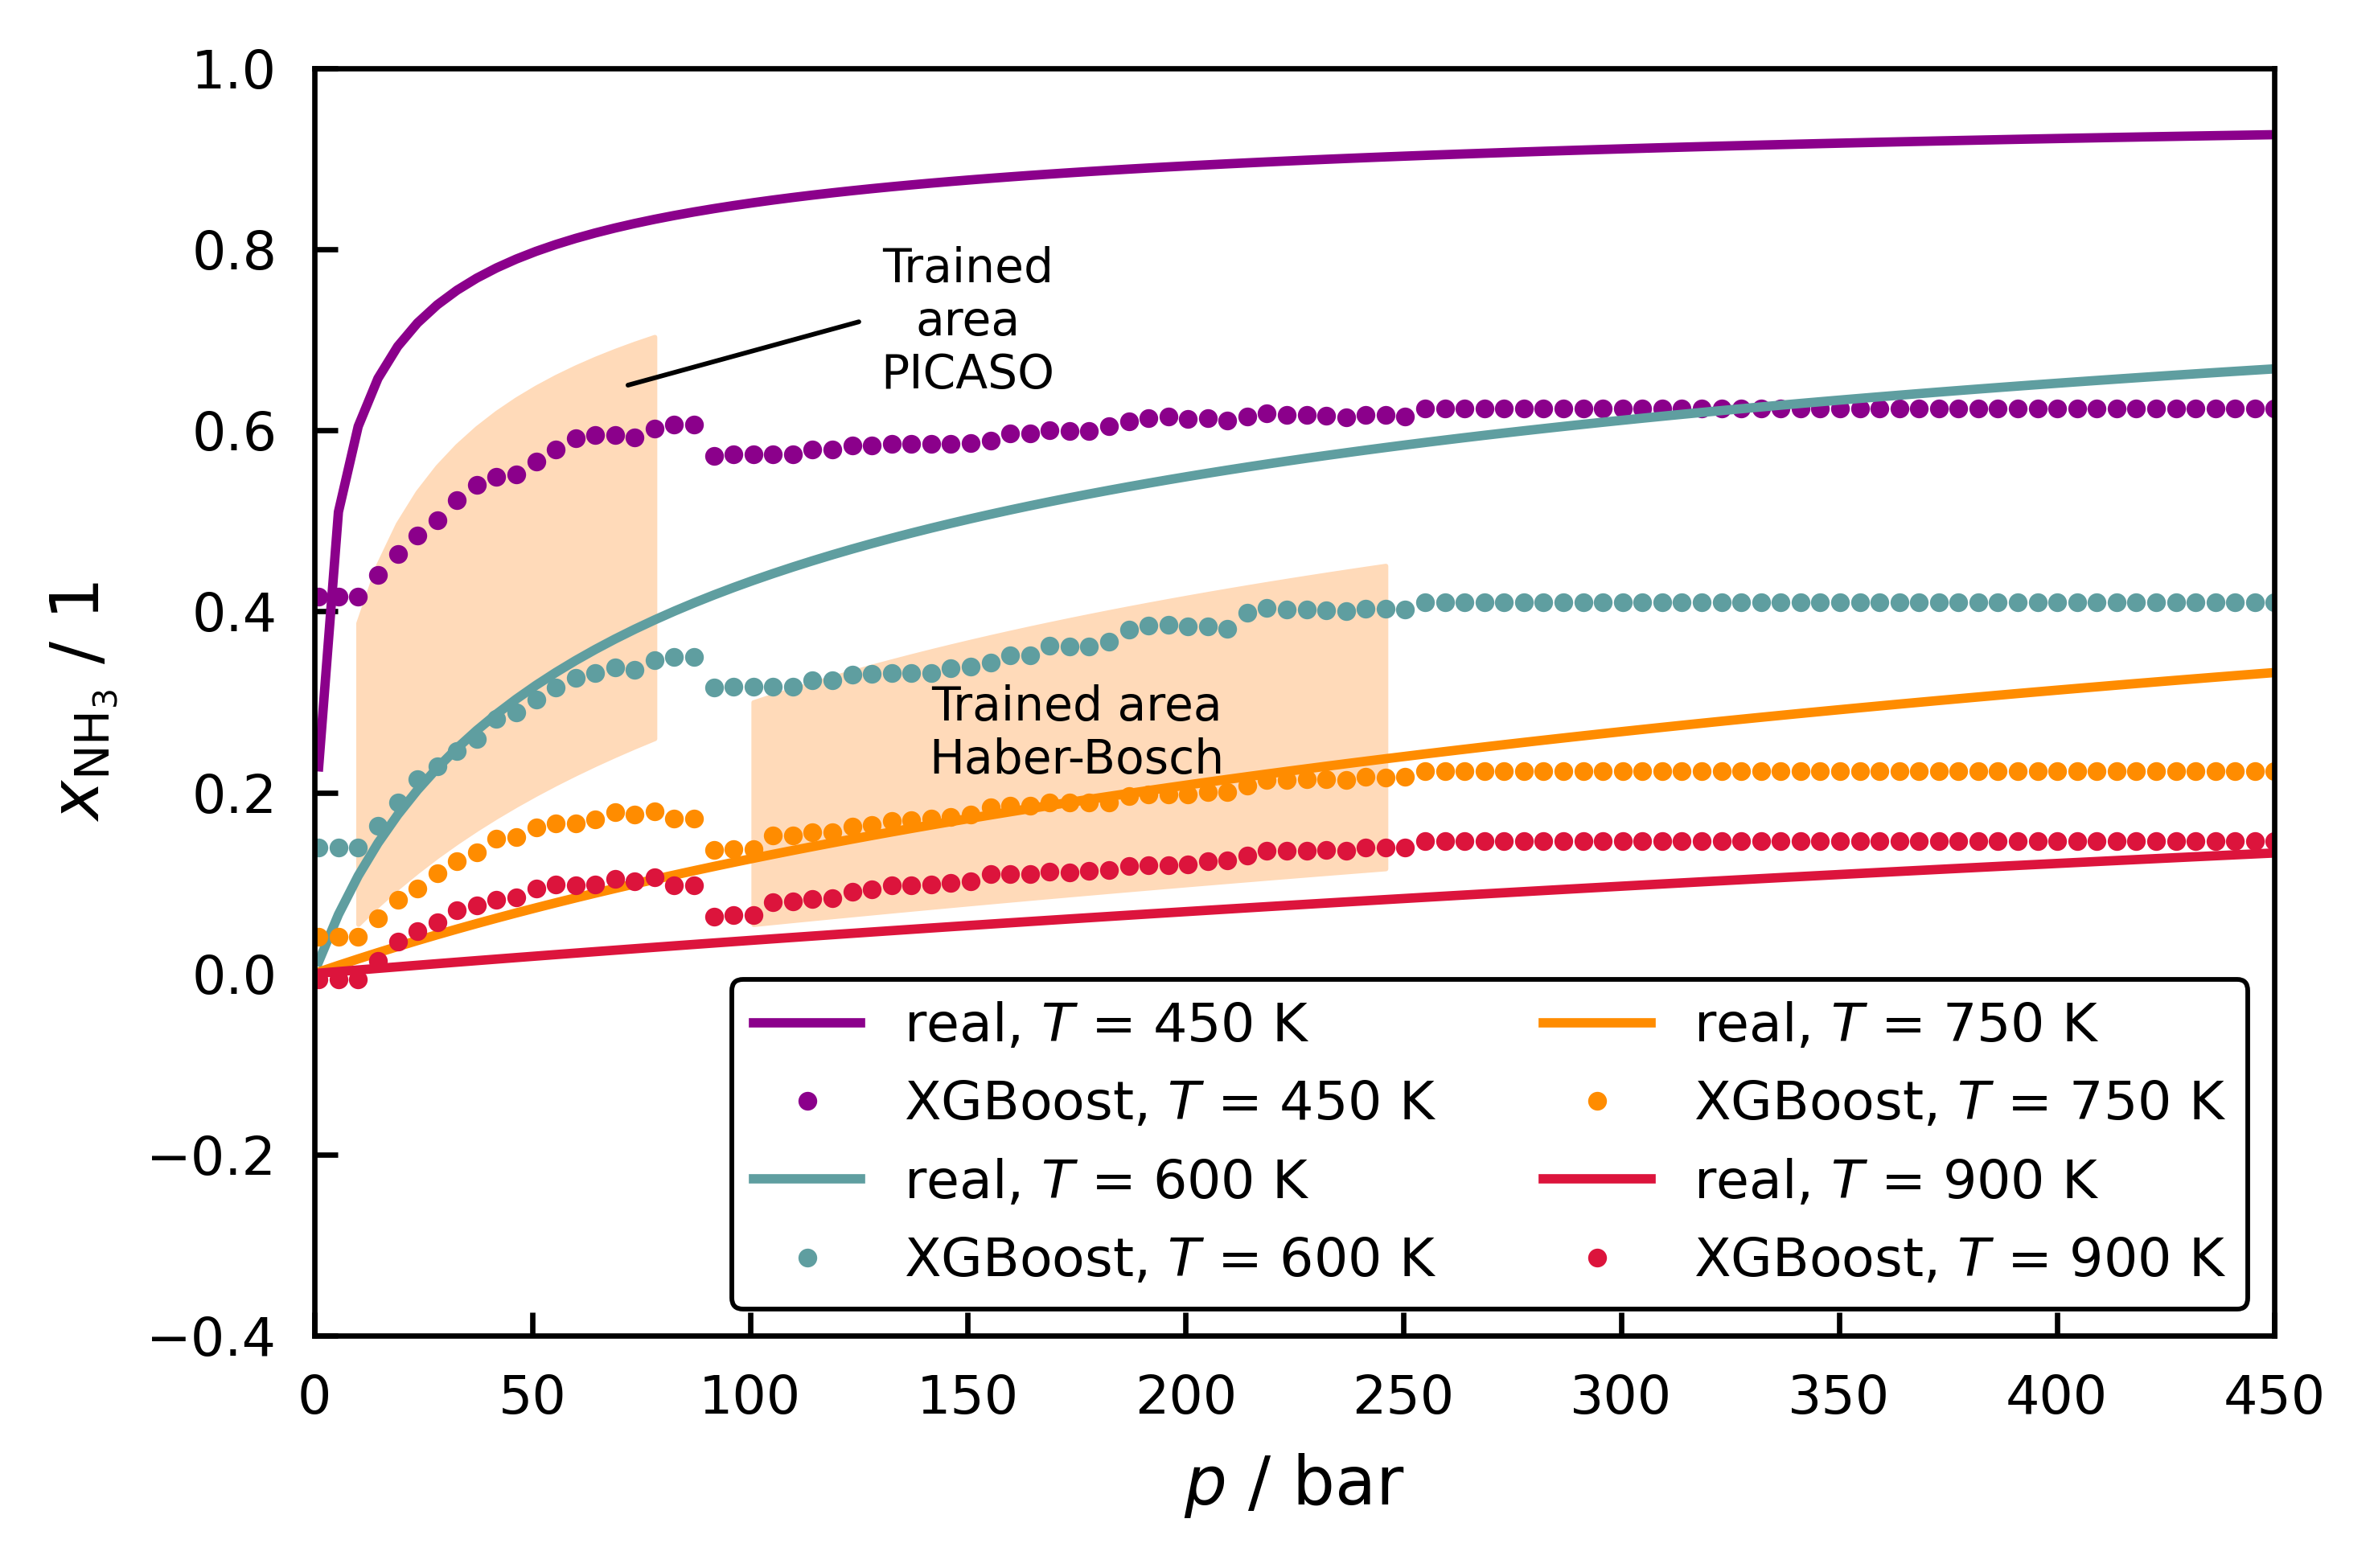

In [51]:
x_NH3_real_1 = y_1
x_NH3_pred_1 = pred_1[:,1]
x_NH3_real_2 = y_2
x_NH3_pred_2 = pred_2[:,1]
x_NH3_real_3 = y_3
x_NH3_pred_3 = pred_3[:,1]
x_NH3_real_4 = y_4
x_NH3_pred_4 = pred_4[:,1]
x_NH3_real_5 = y_5
x_NH3_pred_5 = pred_5[:,1]
x_NH3_real_6 = y_6
x_NH3_pred_6 = pred_6[:,1]
x_NH3_real_7 = y_7
x_NH3_pred_7 = pred_7[:,1]

fig,ax = plt.subplots()

ax.plot(X_1[:,1], x_NH3_real_1, '-', color ='darkmagenta', label = 'real, $T$ = 450 K')
ax.plot(X_1[:,1], x_NH3_pred_1, '.', color ='darkmagenta', label = 'XGBoost, $T$ = 450 K')
#ax.plot(X_2[:,1], x_NH3_real_2, '--', color ='lightgrey')#, label = 'real, T = 500 K')
#ax.plot(X_2[:,1], x_NH3_pred_2, '.', color ='gold', label = 'aNN, T = 500 K')
ax.plot(X_3[:,1], x_NH3_real_3, '-', color ='cadetblue', label = 'real, $T$ = 600 K')
ax.plot(X_3[:,1], x_NH3_pred_3, '.', color ='cadetblue', label = 'XGBoost, $T$ = 600 K')
#ax.plot(X_4[:,1], x_NH3_real_4, '--', color ='lightgrey')#, label = 'real, T = 650 K')
#ax.plot(X_4[:,1], x_NH3_pred_4, '.', color ='mediumorchid', label = 'aNN, T = 650 K')
ax.plot(X_5[:,1], x_NH3_real_5, '-', color ='darkorange', label = 'real, $T$ = 750 K')
ax.plot(X_5[:,1], x_NH3_pred_5, '.', color ='darkorange', label = 'XGBoost, $T$ = 750 K')
#ax.plot(X_6[:,1], x_NH3_real_6, '--', color ='lightgrey')#, label = 'real, T = 850 K')
#ax.plot(X_6[:,1], x_NH3_pred_6, '.', color ='yellowgreen', label = 'aNN, T = 850 K')
ax.plot(X_7[:,1], x_NH3_real_7, '-', color ='crimson', label = 'real, $T$ = 900 K')
ax.plot(X_7[:,1], x_NH3_pred_7, '.', color ='crimson', label = 'XGBoost, $T$ = 900 K')

# ax.axvline(x=10, color='black', linestyle='dashed')
# ax.axvline(x=80, color='black', linestyle='dashed')
# ax.axvline(x=100, color='black', linestyle='dashed')
# ax.axvline(x=250, color='black', linestyle='dashed')


ax.set(xlabel = '$p$ / bar', ylabel = '$x\mathregular{_{NH_3}}$ / 1')
ax.tick_params(direction = 'in') #, length = 20, width = 3)
#ax.set_title('T = const, x_0 = const')
#ax.legend(['$\\mathregular{R^2}$ = ', r2(xi_real,xi_pred)], markerscale=0)

#fill in training areas
#fill in training arreas
X_help = X_1
index_10 = np.where(X_help[:,1] >= 10)[0][0]
index_80 = np.where(X_help[:,1] >= 80)[0][0]
index_100 = np.where(X_help[:,1] >= 100)[0][0]
index_250 = np.where(X_help[:,1] >= 250)[0][0]

# print(index_500)
# print(X_2[index_500:index_650,0])
ax.fill_between(X_1[index_10:index_80, 1],x_NH3_real_2[index_10:index_80], x_NH3_real_4[index_10:index_80], color = 'peachpuff')#, label = 'PICASO', alpha =0.6)
ax.fill_between(X_1[index_100:index_250, 1],x_NH3_real_4[index_100:index_250], x_NH3_real_6[index_100:index_250], color = 'peachpuff')#, label = 'Haber-Bosch')

# Beschriftung Flächen
ax.text(175, 0.265, "Trained area\nHaber-Bosch", ha='center', va='center', fontsize=7, color='black', zorder=100)
# con = ConnectionPatch(xyA=(730, 0.25), coordsA=ax.transData,
#                       xyB=(820,0.45), coordsB=ax.transData, lw = 0.7, zorder=100)
#ax.add_artist(con)

ax.text(150, 0.72, "Trained\narea\nPICASO", ha='center', va='center', fontsize=7, color='black', zorder=100)
con = ConnectionPatch(xyA=(72, 0.65), coordsA=ax.transData,
                      xyB=(125,0.72), coordsB=ax.transData, lw = 0.7, zorder=100)
ax.add_artist(con)

ax.set(xlim=(0,450),ylim=(-0.4,1))

#plt.legend()
#fig.suptitle("Parity Plot")
plt.legend(ncol=2, loc='lower right')
#plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
plt.tight_layout()
plt.show()

In [53]:
#fig.savefig(Path.cwd().parent / 'plots/xgb/TKA_SRA_PB_013_verlauf_extra_4.png', bbox_inches = 'tight')

#### Parity Plot

In [ ]:
# Set the boundaries of X and Y values
bounds = (0,1)

fig,ax = plt.subplots(1, figsize =(3.3,3.3))

# # Reset the limits
# ax[0] = plt.gca()
ax.set_xlim(bounds)
ax.set_ylim(bounds)
# Ensure the aspect ratio is square
ax.set_aspect("equal", adjustable="box")

ax.plot([0, 1], [0, 1], "r-",lw=2 ,transform=ax.transAxes)
ax.plot(x_NH3_real_3, x_NH3_pred_3, '.', color ='rebeccapurple', label = '$T$ = 600 K')
ax.plot(x_NH3_real_2, x_NH3_pred_2, '.', color ='teal', label = '$T$ = 500 K')
ax.plot(x_NH3_real_1, x_NH3_pred_1, '.', color ='orange', label = '$T$ = 450 K')
ax.plot([bounds[0],bounds[1]], [bounds[0] * 1.1, bounds[1] * 1.1], "k--") # Error line
ax.plot([bounds[0],bounds[1]], [bounds[0] * 0.9, bounds[1] * 0.9], "k--") # Error line
ax.text(0.7, 0.9, '+10%')
ax.text(0.8, 0.65, '-10%')
ax.set(xlabel = '$x\mathregular{_{NH_3}}$ / 1', ylabel = '$x\mathregular{_{NH_{3},pred}}$ / 1')
ax.tick_params(direction = 'in') #, length = 20, width = 3)
ax.set_title('T = const, x_0 = const')
ax.legend()
#ax.legend(['$\\mathregular{R^2}$ = ', r2(xi_real,xi_pred)], markerscale=0)

#plt.legend()
#fig.suptitle("Parity Plot")
plt.tight_layout()
plt.show()